# <center>World Wide Wine Society Regression</center>

Ian Kollipara

CS 392 Seminar in Data Science

April 29, 2022

<hr>

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, make_scorer, confusion_matrix, classification_report
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv("WhiteWine.csv", sep=";")

<hr>

## Preprocessing

An important statistic to note is the distribution of values in our dataset.

Text(0.5, 1.0, 'Distribution of Quality Ratings')

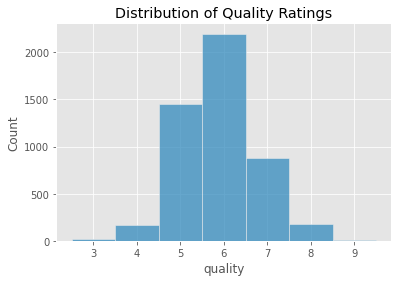

In [11]:
sns.histplot(df, x="quality", discrete=True)
plt.title("Distribution of Quality Ratings")

As we can see here, the ratio models a normal distribution. Because of this, our model will struggle with predicting values that lie on the bottom parts of the curve. To combat this, we will s

Compared to the last model, there's not much difference. However, as we are optimizing for regression as opposed to classification, we want to identify the features that best predict, or rather correlate, with the target attribute: quality.

In [8]:
print("Pearson (Linear)")
print(df.corrwith(df["quality"]).sort_values())
print()
print("Spearman Rank (Monotonic)")
df.corrwith(df["quality"], method="spearman").sort_values()

Pearson (Linear)
density                -0.307123
chlorides              -0.209934
volatile acidity       -0.194723
total sulfur dioxide   -0.174737
fixed acidity          -0.113663
residual sugar         -0.097577
citric acid            -0.009209
free sulfur dioxide     0.008158
sulphates               0.053678
pH                      0.099427
alcohol                 0.435575
quality                 1.000000
dtype: float64

Spearman Rank (Monotonic)


density                -0.348351
chlorides              -0.314488
total sulfur dioxide   -0.196680
volatile acidity       -0.196562
fixed acidity          -0.084485
residual sugar         -0.082070
citric acid             0.018333
free sulfur dioxide     0.023713
sulphates               0.033319
pH                      0.109362
alcohol                 0.440369
quality                 1.000000
dtype: float64

From here, we can see the correlations are not particularly strong, meaning that no matter what we won't have an incredible model. However, we can glean our top 3 attributes to use for the regression model.

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(df[["density", "chlorides", "volatile acidity"]])
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Regession

For all the models here, the primary metrics used to assess the models will be explained variance score, and mean squared error. Although the chosen models may not optimize in that manner, these statistics give a baseline by which the models may be compared.

### Ridge
Ridge is a variant on SDG where the the loss function optimized is:
$$||y - Xw||^2_2 + \alpha ||w||^2_2$$
The parameter we can tune is $\alpha$ as it determines something akin to smoothing. 
#### Hyperparameter Tuning

In [19]:
%%time

param_grid = {"alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 1.5, 2]}

rg = GridSearchCV(Ridge(), param_grid, n_jobs=-1).fit(X_train, y_train)

print("Best Score")
print(rg.best_score_)
print()
print("Best Parameters")
print(rg.best_params_)
print()
rg_model = rg.best_estimator_

Best Score
0.13891464282142993

Best Parameters
{'alpha': 2}

CPU times: user 43.3 ms, sys: 9.47 ms, total: 52.8 ms
Wall time: 82.4 ms


We can see this model is quite weak in score. We can view the aforementioned metrics. In the case of Mean Squared Error, we want the smallest possible value. In the case of Explained Variance Score we want as close to 1 as possible.
#### Evaluation

In [22]:
%%time

y_pred = rg_model.predict(X_test)

print(f"Explained Variance Score: {explained_variance_score(y_test, y_pred)}")
print(f"Mean Squared Error:       {mean_squared_error(y_test, y_pred)}")
print()

Explained Variance Score: 0.14580284676338118
Mean Squared Error:       0.660700096420434

CPU times: user 2.52 ms, sys: 283 µs, total: 2.81 ms
Wall time: 1.88 ms


These are, to be frank, awful results. This is due in part to a dataset without strong correlations. This makes regession far more difficult as there aren't features that relate well to the target.

### Decision Tree Regressor
Decision Trees are industry standard models. They can be applied to regression as well as classification. There's more to analyze and tune compared to Ridge.
#### Hyperparameter Tuning

In [28]:
%%time

param_grid = {
    "criterion": ["squared_error", "absolute_error"],
    "min_samples_split": [2, 4, 6],
    "max_features": [None, "auto", "log2", "sqrt"],
}

dtg = GridSearchCV(DecisionTreeRegressor(), param_grid, n_jobs=-1).fit(X_train, y_train)

print("Best Score")
print(dtg.best_score_)
print()
print("Best Parameters")
print(dtg.best_params_)
print()
dtg_model = dtg.best_estimator_

Best Score
-0.03678258131831043

Best Parameters
{'criterion': 'squared_error', 'max_features': 'sqrt', 'min_samples_split': 6}

CPU times: user 104 ms, sys: 70 ms, total: 174 ms
Wall time: 3.23 s


#### Evaluation

In [29]:
%%time

y_pred = dtg_model.predict(X_test)

print(f"Explained Variance Score: {explained_variance_score(y_test, y_pred)}")
print(f"Mean Squared Error:       {mean_squared_error(y_test, y_pred)}")
print()

Explained Variance Score: -0.019680695040189544
Mean Squared Error:       0.7886506825859595

CPU times: user 326 µs, sys: 2.21 ms, total: 2.53 ms
Wall time: 1.56 ms


These results are also awful.

## Conclusion

These models were not strong indicators of White Wine ratings. I attribute this to low correlation scores. This lack of correlation means there's no strong indicators for the rating. Given this, there's not much to be done in terms of regression. However, I wanted to create some sort of predictor, so I have drafted up a Random Forest/Decision Tree Multi-Class Classifier. By treating the ratings like classes, we can create a classification model to classify based on ratings.

In [40]:
%%time

X = df.drop(columns=["quality"])
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

param_grid = {
    "criterion": ["entropy", "gini"],
    "max_features": ["log2", "sqrt", None],
    "min_samples_split": [1, 2],
    "min_samples_split": [2, 4, 6, 8, 10]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1).fit(X_train, y_train)

print("Best Score")
print(dt_grid.best_score_)
print()
print("Best Params")
print(dt_grid.best_params_)
print()
model = dt_grid.best_estimator_

Best Score
0.5826272961500676

Best Params
{'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 2}

CPU times: user 131 ms, sys: 11.1 ms, total: 142 ms
Wall time: 454 ms


In [41]:
y_pred = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix
[[  0   0   4   2   3   0   0]
 [  0   7  16  17   4   0   0]
 [  0  16 213 116  26   2   0]
 [  1  10  89 360  61  12   1]
 [  0   0  14  68 127  11   0]
 [  0   0   1  10  12  22   0]
 [  0   0   0   0   0   0   0]]

Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.21      0.16      0.18        44
           5       0.63      0.57      0.60       373
           6       0.63      0.67      0.65       534
           7       0.55      0.58      0.56       220
           8       0.47      0.49      0.48        45
           9       0.00      0.00      0.00         0

    accuracy                           0.60      1225
   macro avg       0.36      0.35      0.35      1225
weighted avg       0.59      0.60      0.59      1225



/home/ikollipara/Documents/GitHub/Data-Science-/.venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikollipara/Documents/GitHub/Data-Science-/.venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikollipara/Documents/GitHub/Data-Science-/.venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_

Even in this case, the model is awful. The sheer lack of data for other cases, such as 9 and 3 mean that the classification suffers. This same issue also causes issues in the regression. Overall, I do not reccomend using this model without more data. 